In [6]:
from autora.experiment_runner.synthetic.neuroscience import task_switching
from autora.experimentalist.random import random_pool
from autora.experimentalist.grid import grid_pool
from random_pool_with_fixed_variable import random_pool_with_fixed_variable
from autora.state import StandardState, on_state
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [77]:
experiment = task_switching.task_switching()
pool = grid_pool(experiment.variables)
experimental_space = experiment.run(pool, added_noise=0.0)

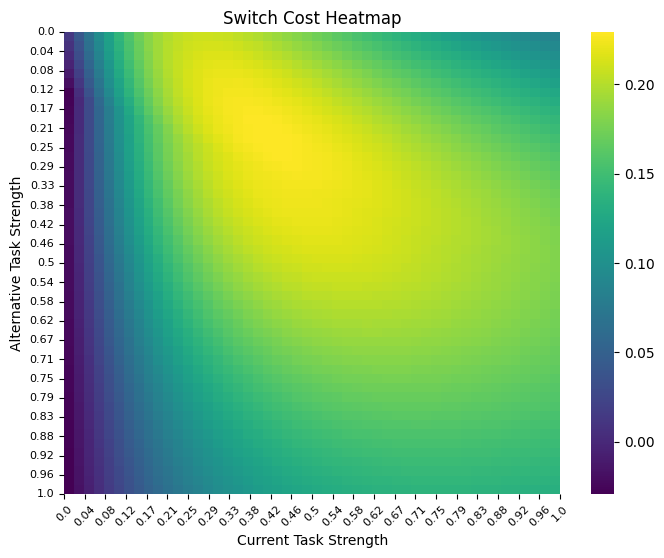

In [78]:
def plot_heatmap(df):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    
    # Use the actual values for tick positions
    ax = sns.heatmap(df, cmap='viridis')
    
    # Set the tick labels to map to actual data ranges
    grid_size = 50
    num_ticks = 25
    ax.set_xticks(np.linspace(0, grid_size, num_ticks))  # Position on the grid
    ax.set_xticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=45)  # Actual values
    ax.set_yticks(np.linspace(0, grid_size, num_ticks))  # Position on the grid
    ax.set_yticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=0)  # Actual values
    ax.tick_params(axis='both', which='major', labelsize=8)

    # Add labels and title
    plt.title("Switch Cost Heatmap")
    plt.xlabel("Current Task Strength")
    plt.ylabel("Alternative Task Strength")

    plt.show()

# Calculate switch cost for each combination of cur_task_strength and alt_task_strength
switch_costs_df = experimental_space.groupby(['cur_task_strength', 'alt_task_strength']).apply(
    lambda x: x.loc[x['is_switch'] == 0, 'cur_task_performance'].values[0] - 
              x.loc[x['is_switch'] == 1, 'cur_task_performance'].values[0],
              include_groups=False
).reset_index(name='switch_cost')
pivot_df = switch_costs_df.pivot(index='alt_task_strength', columns='cur_task_strength', values='switch_cost')
plot_heatmap(pivot_df)

In [83]:
# find row with maximum switch cost in switch_costs_df
max_switch_cost_row = switch_costs_df.loc[switch_costs_df['switch_cost'].idxmax()]
print(max_switch_cost_row)

cur_task_strength    0.420000
alt_task_strength    0.240000
switch_cost          0.229292
Name: 1011, dtype: float64


In [61]:
def only_experimentalist_closed_loop(experimentalist, experiment, num_loops=10, experimentalist_args=dict()):
    """
    A random closed loop experimentalist for the task switching experiment
    """
    # Initialize the state
    s = StandardState(
        variables = experiment.variables,
        conditions = experimentalist(experiment.variables),
        experiment_data = pd.DataFrame(columns=[var.name for var in experiment.variables.independent_variables + experiment.variables.dependent_variables]),
    )
    experimentalist_on_state = on_state(experimentalist, output=["conditions"])
    experiment_runner_on_state = on_state(experiment.run, output=["experiment_data"])
    
    # Run the experiment
    for loop in range(num_loops):
        s = experimentalist_on_state(s, **experimentalist_args)
        s = experiment_runner_on_state(s, random_state=42+loop)
        
    return s

In [62]:
experimentalist = random_pool_with_fixed_variable
experiment = task_switching.task_switching()
num_loops = 100
num_sample_groups_per_loop = 10
s = only_experimentalist_closed_loop(experimentalist, experiment, num_loops=num_loops,
                                     experimentalist_args=dict(num_sample_groups=num_sample_groups_per_loop, fixed_var_name="is_switch"))

/Users/syntactic/miniconda3/envs/autora/lib/python3.10/site-packages/autora/state.py:417: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((a, b), ignore_index=True)


In [65]:
results = s.experiment_data
average_switch_costs = []
for loop in range(num_loops):
    experiment_group = results[loop*num_sample_groups_per_loop:(loop+1)*num_sample_groups_per_loop]
    grouped = experiment_group.groupby(['cur_task_strength', 'alt_task_strength'])
    # Calculate switch cost: performance difference between switch and non-switch conditions
    switch_costs = grouped.apply(lambda x: x.loc[x['is_switch'] == 0, 'cur_task_performance'].values[0] - 
                                          x.loc[x['is_switch'] == 1, 'cur_task_performance'].values[0],
                                          include_groups=False)
    average_switch_cost = switch_costs.mean()
    average_switch_costs.append(average_switch_cost)


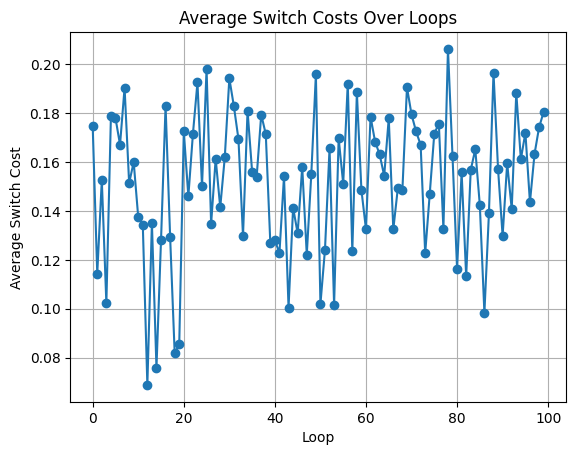

In [66]:
plt.plot(range(num_loops), average_switch_costs, marker='o')
plt.xlabel('Loop')
plt.ylabel('Average Switch Cost')
plt.title('Average Switch Costs Over Loops')
plt.grid(True)
plt.show()